In [1]:
# Install MySql packages
# conda update -n base -c conda-forge conda --yes
# !pip install ipython-sql
# !pip install mysql-connector-python
# !conda install -c conda-forge python-dotenv --yes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import mysql.connector
from mysql.connector import Error
from os import environ, path
from dotenv import load_dotenv

In [3]:
# Read enviromental variables to connect the database
load_dotenv()
password = environ.get('PASSWORD')
host = environ.get('HOST')
database = environ.get('DATABASE')

## Connect to the database and create dataframes for each table

In [4]:
try:
    connection = mysql.connector.connect(host=host ,
                                        database=database,
                                        user='root',
                                        password=password)
    if connection.is_connected():
        print("Succes Connected")
    df_musician = pd.read_sql_query("SELECT * FROM music_and_death.musician;", connection)
    df_birth = pd.read_sql_query("SELECT * FROM music_and_death.birth;", connection)
    df_death = pd.read_sql_query("SELECT * FROM music_and_death.death;", connection)
    df_genre = pd.read_sql_query("SELECT * FROM music_and_death.music_genre;", connection)
    genre = pd.read_sql_query("SELECT * FROM music_and_death.genre;", connection)
    cause_death = pd.read_sql_query("SELECT * FROM music_and_death.cause_death;", connection)
    cities = pd.read_sql_query("SELECT * FROM music_and_death.cities;", connection)
    states = pd.read_sql_query("SELECT * FROM music_and_death.states;", connection)
    countries = pd.read_sql_query("SELECT * FROM music_and_death.countries;", connection)
    
    
except Error as e:
    print("Error closing connection")

# Concatenate tables
else:
    # Concatenate musician and death dataframes
    df = pd.concat([df_musician, df_birth], axis=1)
    df = pd.concat([df, df_death], axis=1)
    df = pd.merge(df, cause_death, on=["death_id", "death_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, df_genre, on=["musician_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, genre, on=["genre_id"])
    # rearrange columns
    df = df.iloc[:, [0, 1, 2, 3, 5, 7, 8, 9, 11, 6, 4, 10]]
    
finally:
    connection.close()

Succes Connected


/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordat

## Merge and clean the cities, states and countries tables

In [5]:
# merge cities table with states table
place = cities.merge(states, 
                      left_on=cities["state_id"], 
                      right_on=states["id"])

# drop duplicate keys
place.drop(['key_0', 'state_id', 'id_y'], axis=1, inplace=True)

# merge resulted table with countries table
place = place.merge(countries, 
                        left_on=place["country_id"],
                        right_on=countries["id"])

# drop duplicated keys
place.drop(['key_0', 'country_id', 'id', 'iso2', 'capital'], 
              axis=1, 
              inplace=True)

# rename column names
place.rename(
    columns={'name_x': 'City', 
             'name_y': 'State', 
             'name': 'Country', 
             'id_x': 'city_id'},
    inplace=True
)

##  Drop columns with not use

In [6]:
df.drop(['middle_name', 'death_id', "death_date", "genre_id", "birth"], 
        axis=1, 
        inplace=True)

In [7]:
df

,musician_id,stage_name,stage_lastname,death_age,cause,genre,birthplace_id
0,1,John,Lennon,40,homicide,rock,50337
1,2,Kurt,Cobain,27,suicide,rock,110979
2,17,Chris,Cornell,52,suicide,rock,126104
3,18,Chester,Bennington,41,suicide,rock,124148
4,32,Ian,Curtis,23,suicide,rock,51499
...,...,...,...,...,...,...,...
311,190,Woody,Guthrie,55,brain disorder,folk,123401
312,312,Ezra,Carter,76,unknown,folk,126050
313,241,Baby,Huey,26,drug overdose,funk,125084
314,307,Robbie,McIntosh,24,drug overdose,funk,49346


In [8]:
place

,city_id,City,State,Country
0,52,Ashkāsham,Badakhshan,Afghanistan
1,68,Fayzabad,Badakhshan,Afghanistan
2,78,Jurm,Badakhshan,Afghanistan
3,84,Khandūd,Badakhshan,Afghanistan
4,115,Rāghistān,Badakhshan,Afghanistan
...,...,...,...,...
148261,131496,Redcliff,Midlands Province,Zimbabwe
148262,131502,Shangani,Midlands Province,Zimbabwe
148263,131503,Shurugwi,Midlands Province,Zimbabwe
148264,131504,Shurugwi District,Midlands Province,Zimbabwe


## Merge musician info dataframe with place dataframe

In [9]:
# merge df and place dataframes
musician = df.merge(place, 
                    left_on=df['birthplace_id'], 
                    right_on=place['city_id'])

# drop unused columns
musician.drop(['birthplace_id', 'city_id', 'key_0'], axis=1, inplace=True)

In [10]:
musician

,musician_id,stage_name,stage_lastname,death_age,cause,genre,City,State,Country
0,1,John,Lennon,40,homicide,rock,Liverpool,England,United Kingdom
1,271,Rory,Storm,34,suicide,rock,Liverpool,England,United Kingdom
2,188,Brian,Epstein,32,drug overdose,rock,Liverpool,England,United Kingdom
3,2,Kurt,Cobain,27,suicide,rock,Aberdeen,Washington,United States
4,17,Chris,Cornell,52,suicide,rock,Seattle,Washington,United States
...,...,...,...,...,...,...,...,...,...
310,311,Nick,Drake,26,drug overdose,folk,Yangon,Yangon Region,Myanmar
311,190,Woody,Guthrie,55,brain disorder,folk,Okemah,Oklahoma,United States
312,241,Baby,Huey,26,drug overdose,funk,Richmond,Indiana,United States
313,307,Robbie,McIntosh,24,drug overdose,funk,Dundee,Scotland,United Kingdom


## Create plots to observe the data

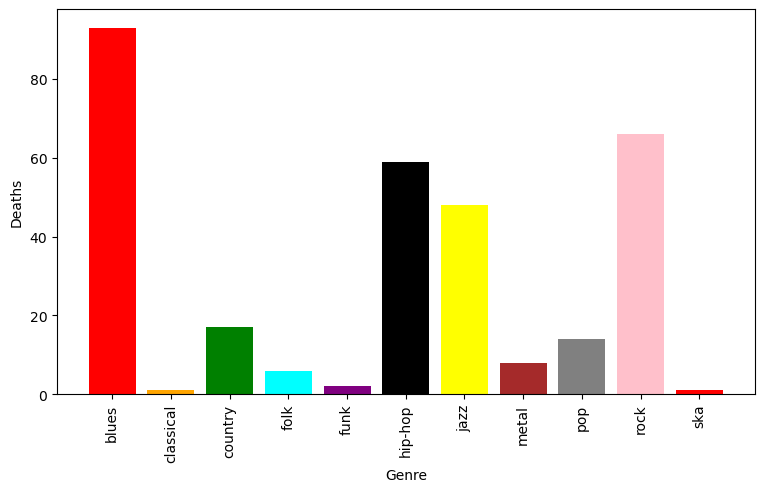

In [11]:
# Bar plot to show deaths per music genre 

# Create a new music table using genre as indez and size of each genre
df_n = musician.pivot_table(index=['genre'], aggfunc='size')

# plot the data
plt.figure(figsize=(9,5))
plt.bar(df_n.index, df_n, color=
        ['red', 'orange', 'green',
         'cyan', 'purple', 'black',
         'yellow', 'brown', 'grey', 'pink'])
plt.ylabel("Deaths")
plt.xlabel("Genre")
plt.xticks(rotation='vertical')
plt.show()

## Cause of death per music genre

In [12]:
df_cd = musician.pivot_table(index=['cause', 'genre'], aggfunc='size')
df_cd

cause                              genre  
AIDS                               pop         1
                                   rock        1
Burned                             blues       1
Falling                            rock        1
accidental self-inflicted gunshot  blues       1
                                              ..
unknown                            blues      10
                                   country     1
                                   folk        1
                                   jazz        8
                                   pop         1
Length: 78, dtype: int64

# Questions

## Most common Death Ages


In [13]:
n_da = musician['death_age'].value_counts().nlargest(15)

In [14]:
n_da

27    20
32    14
28    12
37    11
25    10
34    10
24    10
30     9
21     9
36     8
26     8
39     8
29     7
33     7
40     7
Name: death_age, dtype: int64

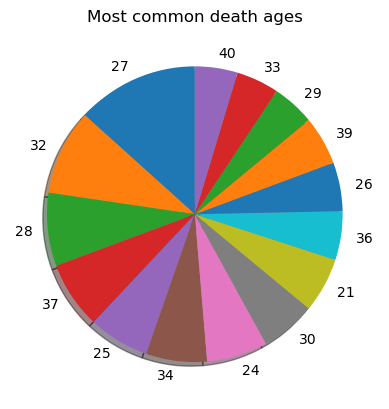

In [15]:

plt.pie(n_da.values, labels=n_da.index, startangle=90, shadow=True)
plt.title("Most common death ages")
# plt.legend(title='Death age', loc=(1, 0.25))
plt.show()

In [16]:
n_da.values

array([20, 14, 12, 11, 10, 10, 10,  9,  9,  8,  8,  8,  7,  7,  7])

## Most common Music Genre

In [17]:
n_mg = musician['genre'].value_counts()

In [18]:
n_mg

blues        93
rock         66
hip-hop      59
jazz         48
country      17
pop          14
metal         8
folk          6
funk          2
ska           1
classical     1
Name: genre, dtype: int64

<BarContainer object of 11 artists>

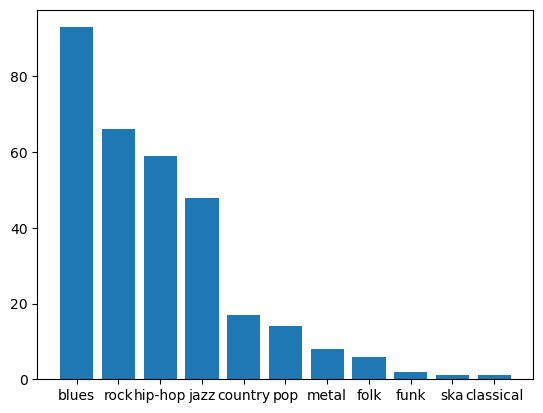

In [19]:
plt.bar(n_mg.index, n_mg.values)

# Places

### Most common Countries

In [20]:
n_places = musician['Country'].value_counts()

In [21]:
n_places

United States     259
United Kingdom     29
Germany             3
Canada              2
Australia           2
Jamaica             2
Lithuania           2
Finland             1
Belarus             1
India               1
Sweden              1
Netherlands         1
Greece              1
South Africa        1
Brazil              1
Mexico              1
Haiti               1
Norway              1
New Zealand         1
Colombia            1
Turkey              1
Tanzania            1
Myanmar             1
Name: Country, dtype: int64

### Most common States

In [22]:
n_states = musician['State'].value_counts().nlargest(20)

In [23]:
n_states

New York          29
Mississippi       27
England           23
Texas             21
California        20
Tennessee         16
Louisiana         16
Alabama           13
Georgia           12
Pennsylvania      10
Illinois           8
Arkansas           8
Missouri           7
Washington         7
Scotland           6
North Carolina     6
Ohio               6
Virginia           6
Florida            5
Michigan           4
Name: State, dtype: int64

### Most common Cities

In [24]:
n_cities = musician['City'].value_counts().nlargest(20)

In [25]:
n_cities

New York City    17
New Orleans       9
London            9
Philadelphia      8
Memphis           8
Los Angeles       8
Chicago           7
Birmingham        7
Queens            4
Liverpool         3
Atlanta           3
Richmond          3
Detroit           3
Brooklyn          3
Dallas            3
Glasgow           2
Knoxville         2
Newark            2
Jackson           2
Oakland           2
Name: City, dtype: int64

## Death genre - cause

In [26]:
n_cd_gr = musician.loc[:, ['genre', 'cause']].value_counts()

In [27]:
n_cd_gr

genre    cause                  
hip-hop  homicide                   58
blues    heart disease              23
         cancer                     14
jazz     heart disease              13
rock     drug overdose              12
                                    ..
jazz     tuberculosis                1
metal    aircraft accident           1
         car/motorcycle accident     1
pop      AIDS                        1
ska      suicide                     1
Length: 78, dtype: int64

In [28]:
n_cd_gr = n_cd_gr.reset_index()
n_cd_gr.rename(columns={0: 'deaths'}, inplace=True)

In [29]:
n_cd_gr

,genre,cause,deaths
0,hip-hop,homicide,58
1,blues,heart disease,23
2,blues,cancer,14
3,jazz,heart disease,13
4,rock,drug overdose,12
...,...,...,...
73,jazz,tuberculosis,1
74,metal,aircraft accident,1
75,metal,car/motorcycle accident,1
76,pop,AIDS,1


### Blues 

In [30]:
n_blues = n_cd_gr.loc[n_cd_gr['genre'] == 'blues', ]

In [31]:
n_blues

,genre,cause,deaths
1,blues,heart disease,23
2,blues,cancer,14
6,blues,unknown,10
9,blues,homicide,8
13,blues,diabetes,6
14,blues,pneumonia,5
15,blues,car/motorcycle accident,5
18,blues,brain disorder,4
24,blues,aircraft accident,3
26,blues,alcohol related,3


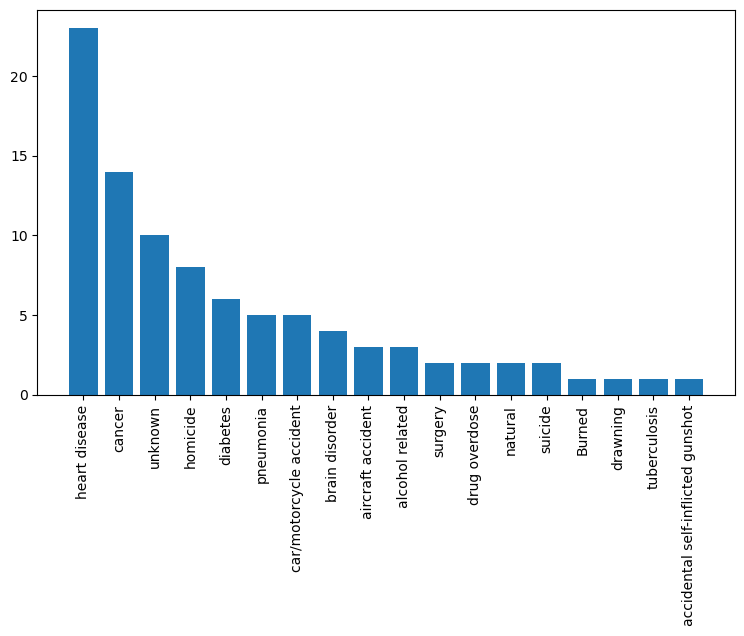

In [32]:
plt.figure(figsize=(9,5))
plt.bar(n_blues['cause'], n_blues['deaths'])
plt.xticks(rotation='vertical')
plt.show()


### Rock

In [33]:
n_rock = n_cd_gr.loc[n_cd_gr['genre'] == 'rock', ]

In [34]:
n_rock

,genre,cause,deaths
4,rock,drug overdose,12
5,rock,suicide,10
7,rock,car/motorcycle accident,9
8,rock,alcohol related,9
10,rock,heart disease,8
17,rock,drawning,4
20,rock,aircraft accident,3
35,rock,pneumonia,2
38,rock,brain disorder,2
39,rock,cancer,2


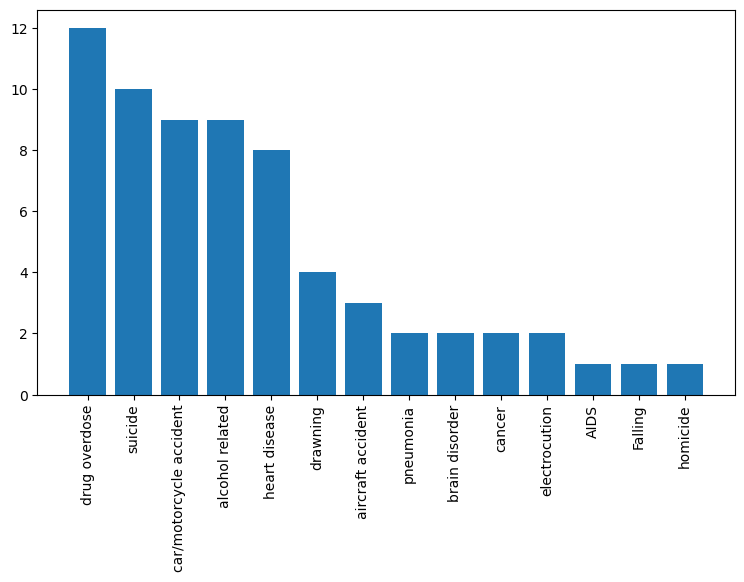

In [35]:
plt.figure(figsize=(9,5))
plt.bar(n_rock['cause'], n_rock['deaths'])
plt.xticks(rotation='vertical')

plt.show()

### Rock vs Blues

In [36]:
n_cause = n_cd_gr['cause'].unique()
n_blues_deaths = n_blues['deaths']
n_rock_deaths = n_rock['deaths']
x_axis = np.arange(len(n_cause))

In [42]:
len(n_blues['cause'])

18

In [38]:
n_rock['cause'].count()

14

In [39]:
n_cause

array(['homicide', 'heart disease', 'cancer', 'drug overdose', 'suicide',
       'unknown', 'car/motorcycle accident', 'alcohol related',
       'diabetes', 'pneumonia', 'aircraft accident', 'drawning',
       'brain disorder', 'surgery', 'natural', 'electrocution', 'Burned',
       'kidney related', 'AIDS', 'Falling',
       'accidental self-inflicted gunshot', 'tuberculosis'], dtype=object)

## Most common Cause o deaths

In [40]:
n_cause_death = musician['cause'].value_counts()

In [41]:
n_cause_death

homicide                             71
heart disease                        51
drug overdose                        26
cancer                               26
car/motorcycle accident              23
unknown                              21
suicide                              16
aircraft accident                    16
alcohol related                      14
brain disorder                       11
pneumonia                            10
diabetes                              8
drawning                              6
surgery                               3
electrocution                         2
accidental self-inflicted gunshot     2
AIDS                                  2
natural                               2
tuberculosis                          2
Burned                                1
Falling                               1
kidney related                        1
Name: cause, dtype: int64

# Correlation

### Genre - Cause of death

### Age - Cause of death

### Genre - Age